# Timeseries classification with a Transformer model

## Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
import sys
from matplotlib import pyplot as plt

## Load the dataset

자동차 하위 시스템에 특정 증상이 있는지 여부를 진단하는 것.

500개의 엔진 소음 측정 및 class로 구성

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [3]:
x_train

array([[[-0.55886975, -0.53809641, -0.4723142 , ..., -0.72274825,
         -0.43076753, -0.08442993]],

       [[ 0.59877848,  0.35105249,  0.16529298, ...,  0.89801912,
          1.2737284 ,  1.446546  ]],

       [[-0.33121335, -0.49904946, -0.71180593, ..., -0.50921764,
         -0.71925329, -0.88824043]],

       ...,

       [[ 0.13503653, -0.25052377, -0.59185988, ..., -1.1524484 ,
         -0.95935677, -0.70397757]],

       [[ 0.30846193,  0.31761688,  0.28230493, ...,  1.2945808 ,
          1.7510204 ,  2.0910614 ]],

       [[ 0.28637012,  0.39110407,  0.54482649, ..., -0.28544349,
         -0.24490132, -0.11820702]]])

In [4]:
x_train.shape

(3601, 1, 500)

In [5]:
y_train

array([0, 1, 1, ..., 0, 0, 0])

In [6]:
y_train.shape

(3601,)

In [7]:
class CustomDataset(Dataset): 
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index): 
        return self.x[index], self.y[index]

In [8]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 8,
          'pin_memory' : True}

val_rate = 0.2

x_train = x_train[:int(len(x_train)*(1-val_rate))]
y_train = y_train[:int(len(y_train)*(1-val_rate))]
x_val = x_train[int(len(x_train)*(1-val_rate)):]
y_val = y_train[int(len(x_train)*(1-val_rate)):]


x_train = torch.FloatTensor(x_train)
y_train = torch.tensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.tensor(y_val)
tr_dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset=tr_dataset, **params)

In [9]:
print(f'Train : {len(x_train)}, Validation : {len(x_val)}, Test : {len(x_test)}')

Train : 2880, Validation : 576, Test : 1320


## Build the model

Our model processes a tensor of shape ```(batch size, features, sequence length)```, where sequence length is the number of time steps and features is each input timeseries.

You can replace your classification RNN layers with this one: the inputs are fully compatible!

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [12]:
class transformer_encoder(nn.Module):
    def __init__(self, input_shape, num_heads, ff_dim, dropout=0):
        super().__init__()
        hidden_size = input_shape[0]
        self.ln = nn.LayerNorm(input_shape[1], eps=1e-6)
        self.Attn = nn.MultiheadAttention(embed_dim=input_shape[1], num_heads=num_heads, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.ff_layer = nn.Sequential(
            nn.LayerNorm(input_shape, eps=1e-6),
            nn.Conv1d(hidden_size, ff_dim, kernel_size=1),
            nn.Dropout(dropout),
            nn.Conv1d(ff_dim, hidden_size, kernel_size=1)
        )
       
    def forward(self, inputs):
        x = self.ln(inputs)
        x, x_weights = self.Attn(x, x, x)
        x = self.dropout(x)
        res = x+inputs
        x = self.ff_layer(res)
        return x+res

In [13]:
class MLP(nn.Module):
    def __init__(self, mlp_units, dropout, activation=nn.ReLU, output_activation=nn.LogSoftmax):
        super().__init__()
        self.mlp_layers = []
        for i in range(len(mlp_units)-1):
            act = activation if i < len(mlp_units)-2 else output_activation
            if i!=len(mlp_units)-1:
                self.mlp_layers += [nn.Linear(mlp_units[i], mlp_units[i+1]), nn.Dropout(dropout), act()]
            else:
                self.mlp_layers += [nn.Linear(mlp_units[i], mlp_units[i+1]), act()]
        self.mlp_layers = nn.Sequential(*self.mlp_layers)
    def forward(self, inputs):
        return self.mlp_layers(inputs)

In [14]:
class build_model(nn.Module):
    def __init__(
        self, 
        hidden_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0
    ):
        super().__init__()
        self.num_transformer_blocks = num_transformer_blocks
        self.encoder = transformer_encoder(hidden_size, num_heads, ff_dim, dropout)
        self.mlp = MLP(mlp_units, mlp_dropout)
        
    def forward(self, inputs):
        x = inputs
        for _ in range(self.num_transformer_blocks):
            x = self.encoder(x)
        x = x.mean(dim=(1))
        output = self.mlp(x)
        return output

### Train and evaluate

head_size issue

In [27]:
input_shape = x_train.shape[1:]
model = build_model(
    input_shape,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[input_shape[1], 128, n_classes],
    mlp_dropout=0.4,
    dropout=0.25,
).to(device)

summary(model, input_size = (3601, 1, 500))

Layer (type:depth-idx)                   Output Shape              Param #
build_model                              --                        --
├─transformer_encoder: 1-1               [3601, 1, 500]            --
│    └─LayerNorm: 2-1                    [3601, 1, 500]            1,000
│    └─MultiheadAttention: 2-2           [3601, 1, 500]            --
│    └─Dropout: 2-3                      [3601, 1, 500]            --
│    └─Sequential: 2-4                   [3601, 1, 500]            --
│    │    └─LayerNorm: 3-1               [3601, 1, 500]            1,000
│    │    └─Conv1d: 3-2                  [3601, 4, 500]            8
│    │    └─Dropout: 3-3                 [3601, 4, 500]            --
│    │    └─Conv1d: 3-4                  [3601, 1, 500]            5
├─transformer_encoder: 1-2               [3601, 1, 500]            (recursive)
│    └─LayerNorm: 2-5                    [3601, 1, 500]            (recursive)
│    └─MultiheadAttention: 2-6           [3601, 1, 500]        

In [28]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.NLLLoss()

In [18]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [19]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    correct = 0
    
    model.train() 

    for idx, [x, y] in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                        
        x = x.to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(x)
            train_loss = loss_fn(predictions, y)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        _, predicted = torch.max(predictions.data, 1)
        epoch_loss += train_loss.item()
        correct += (predicted == y).sum().item()
        
    return epoch_loss/len(train_data), correct

In [20]:
def validation(model, val_data, loss_fn):
    model.eval()
    
    with torch.no_grad():
        predictions = model.forward(val_data[0])
        val_loss = loss_fn(predictions, val_data[1])
        _, predicted = torch.max(predictions.data, 1)
        correct = (predicted == val_data[1]).sum().item()
        
    return val_loss.item()/len(val_data), correct/len(val_data[0])

In [29]:
# %%time
epochs = 200
history = dict()
early_stopping = EarlyStopping(patience=10, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss, n_corr = train(model, dataloader, optimizer, loss_fn, use_fp16=True)
    epoch_acc = n_corr/len(tr_dataset)
    val_loss, val_acc = validation(model, [x_val, y_val], loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    history.setdefault('acc', []).append(epoch_acc) 
    history.setdefault('val_acc', []).append(val_acc) 
    
    sys.stdout.write(
        "\r" + f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Train Accuracy: {epoch_acc:.4}"\
        f"  Validation Loss: {val_loss:.4}"\
        f"  Validation Accuracy: {val_acc:.4}"\
                    )
    
    if early_stopping.validate(val_loss):
        break

[Train] Epoch : 157  Train Loss: 0.1928  Train Accuracy: 0.8931  Validation Loss: 0.02066  Validation Accuracy: 0.9878Training process is stopped early....


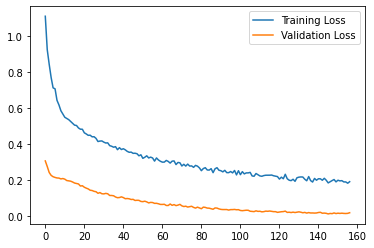

In [30]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

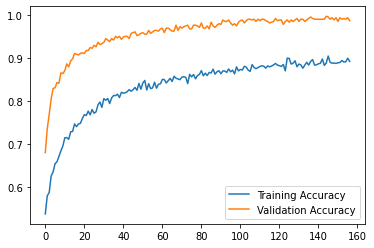

In [31]:
plt.plot(history["acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

## Test

In [32]:
with torch.no_grad(): 
    predictions = model(torch.FloatTensor(x_test).to(device)).detach().cpu() 
    _, predicted = torch.max(predictions.data, 1)
    correct = (predicted == torch.Tensor(y_test)).sum().item()
    
print(f'Acc: {correct/len(x_test):.4}')

Acc: 0.8288


---